In [46]:
import pandas as pd
import numpy as np
from skimage import io
import matplotlib.pyplot as plt
from xiaolei.chain.tracking import dt_track_1
import trackpy as tp

In [47]:
def get_angle_and_arc(traj, order_pNo):
    data = pd.DataFrame()
    for frame in traj.frame.drop_duplicates():
        subtraj = traj.loc[traj.frame==frame]        
        count = 0
        bond_length = 0
        theta = []
        s = []
        k = 0
        for i in order_pNo:
            if k == 0:
                try:
                    x1 = subtraj.x.loc[subtraj.particle==i].values[0]
                    y1 = subtraj.y.loc[subtraj.particle==i].values[0]
                    xt = x1
                    yt = y1
                    k += 1 # make sure we have particle 1
                    continue
                except:
                    continue
            x2 = subtraj.x.loc[subtraj.particle==i].values[0]
            y2 = subtraj.y.loc[subtraj.particle==i].values[0]
            theta.append(np.arctan((y2-y1)/(x2-x1)))
            bond_length += ((y2-yt)**2 + (x2-xt)**2)**.5
            s.append(bond_length)
            xt = x2
            yt = y2
        subdata = pd.DataFrame().assign(s=s, theta=theta, frame=frame)
        data = data.append(subdata)
    return data

In [11]:
traj = pd.read_csv(r'R:\Dip\DNA_chain\fluorescent\substack_lp\tracking.csv')
order_pNo = np.array([0,1,2,3,4,5,6])
aaa = get_angle_and_arc(traj, order_pNo)

In [45]:
aaa.to_csv(r'R:\Dip\DNA_chain\fluorescent\substack_lp\arc_and_angle.csv')

* Compute fourier expansion coefficients

In [4]:
def fourier_coef(data, n=10):
    # data is pd.DataFrame containing theta and arc_length
    # n is number of expanded terms
    L = data.s.max()
    data = data.assign(ds=data.s.diff())
    a = []
    for i in range(0, n):
        coef = 0
        for num, r in data.iterrows():
            if num == 0:
                coef += r.theta * np.cos(i*np.pi*r.s) * r.s
                continue
            coef += r.theta * np.cos(i*np.pi*r.s) * r.ds
        coef = coef * 2 / L
        a.append(coef)
    return a

In [58]:
data1 = pd.read_csv(r'R:\Dip\DNA_chain\fluorescent\substack_lp\arc_and_angle.csv', index_col=0)

In [59]:
data1.head()

,s,theta,frame
0,31.912217,-0.269773,1
1,65.552701,-0.516954,1
2,99.696777,-0.507185,1
3,131.949888,-0.474057,1
4,164.331266,-0.448824,1


In [134]:
data = data1.loc[data1.frame==1]
L = data.s.max()
data = data.assign(ds=data.s.diff())
a = []
cos = []
ds = []
for i in range(1, 13):
    coef = 0
    for num, r in data.iterrows():
        if num == 0:
            cos_i = np.cos(i*np.pi*r.s/210/2)
            cos.append(cos_i)
            ds.append(r.s)
            coef += r.theta * cos_i * r.s
            continue
        cos_i = np.cos(i*np.pi*(r.s-r.ds/2)/210)
        cos.append(cos_i)
        coef += r.theta * cos_i * r.ds
        ds.append(r.ds)
    coef = coef * (2 / L)**2
    a.append(coef)


In [135]:
cos = np.array(cos).reshape(12, 6)
ds = np.array(ds).reshape(12, 6)
theta = np.ones((12, 1)) @ np.array(data.theta).reshape(1, 6)
item_data = (cos*ds*0.1)*theta*(2/21)**0.5
i_data = pd.DataFrame(data=item_data, columns=['t1', 't2', 't3', 't4', 't5', 't6'])
i_data.assign(sum=i_data.sum(axis=1)).to_csv(r'R:\Dip\DNA_chain\fluorescent\substack_lp\idata.csv', index=False)

In [133]:
cos

array([[ 0.9716455 ,  0.42715484,  0.89930152,  0.70016159,  0.36409571,
         0.70263075],
       [ 0.88818995, -0.63507748,  0.61748644, -0.0195475 , -0.73486862,
        -0.01262007],
       [ 0.75436604, -0.96970769,  0.21131148, -0.72753441, -0.89922075,
        -0.72036525],
       [ 0.57776279, -0.19335319, -0.23742098, -0.99923579,  0.08006378,
        -0.99968147],
       [ 0.36839518,  0.80452418, -0.63833757, -0.67171862,  0.95752251,
        -0.68444862],
       [ 0.13813625,  0.88066599, -0.91069492,  0.05861263,  0.6171959 ,
         0.03785217],
       [-0.09995624, -0.05216269, -0.99964108,  0.75379525, -0.50808574,
         0.73764083],
       [-0.33238032, -0.92522909, -0.88726256,  0.99694433, -0.98717958,
         0.99872607],
       [-0.54595544, -0.73826948, -0.59619205,  0.64224899, -0.21076997,
         0.66583047],
       [-0.72856998,  0.29451832, -0.18505028, -0.09758818,  0.8336987 ,
        -0.06306016],
       [-0.86986804,  0.98987933,  0.26336005, -0.

PermissionError: [Errno 13] Permission denied: 'R:\\Dip\\DNA_chain\\fluorescent\\substack_lp\\idata.csv'

0    -1.775283
1     0.129054
2     1.298364
3     0.996212
4     0.054113
5    -0.285191
6     0.196079
7     0.651455
8     0.416726
9    -0.112325
10   -0.067743
11    0.638140
dtype: float64

In [13]:
data = pd.DataFrame()
for frame in aaa.frame.drop_duplicates():
    subdata = aaa.loc[aaa.frame==frame]
    a = fourier_coef(subdata, n=12)
    subdata = pd.DataFrame().assign(a=a, frame=frame)
    data = data.append(subdata)

In [44]:
data.to_csv(r'R:\Dip\DNA_chain\fluorescent\substack_lp\fourier_coef.csv')

In [15]:
subdata = data.loc[0]
acdata = subdata.rename(columns={'a': 'ac', 'frame': 'Name'}).reset_index()

In [17]:
def corrT(autocorr_data):
    # Calculate temporal correlation function
    # autocorr_data is a pd.DataFrame containing columns (Name, ac)
    length = len(autocorr_data)
    autocorr_data.ac = autocorr_data.ac - autocorr_data.ac.mean()
    Isq = (np.array(autocorr_data.ac)**2).sum() / length
    C = np.zeros((length, 1)).squeeze()
    t = np.zeros((length, 1)).squeeze()
    for tin in range(0, length):
        count = 0
        Ct = 0
        for ts in range(0, length-tin):
            d1 = autocorr_data.loc[ts]
            d2 = autocorr_data.loc[ts+tin]
            Ct += d2.ac*d1.ac
            count += 1
        Ct = Ct / count / Isq
        C[tin] = Ct
        t[tin] = tin
    return pd.DataFrame().assign(dt=t, C=C)

In [18]:
ac = corrT(acdata.loc[acdata.Name<200])

S:\Anaconda\3\lib\site-packages\pandas\core\generic.py:5096: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


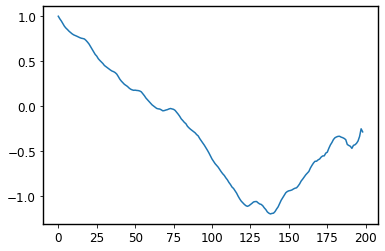

In [20]:
plt.plot(ac.dt, ac.C)

In [37]:
dt = 100
varan = []
for i in data.index.drop_duplicates():
    print('a' + str(i))
    varan_tmp = 0
    count = 0
    for t in range(1, 700):
        an1 = data.loc[data.frame==t].loc[i].a
        an2 = data.loc[data.frame==t+dt].loc[i].a
        varan_tmp += (an2 - an1)**2
        count += 1
    varan_tmp /= count
    varan.append(varan_tmp)

a0
a1
a2
a3
a4
a5
a6
a7
a8
a9
a10
a11


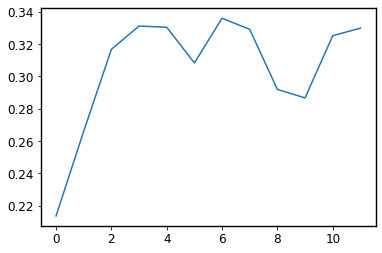

In [40]:
plt.plot(range(0, 12), varan)

In [22]:
order_pNo = np.array([0,1,2,3,4,5,6])
count = 0
k = 0
bond_length = 0
theta = []
s = []
for i in order_pNo:
    if k == 0:
        try:
            x1 = traj.x.loc[traj.particle==i].values[0]
            y1 = traj.y.loc[traj.particle==i].values[0]
            xt = x1
            yt = y1
            k += 1
            continue
        except:
            continue
    x2 = traj.x.loc[traj.particle==i].values[0]
    y2 = traj.y.loc[traj.particle==i].values[0]
    theta.append(np.arctan((y2-y1)/(x2-x1)))
    bond_length += ((y2-yt)**2 + (x2-xt)**2)**.5
    s.append(bond_length)
    xt = x2
    yt = y2

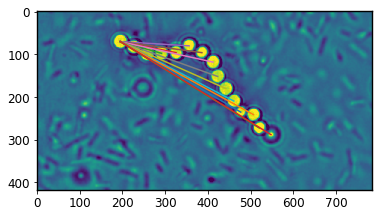

In [25]:
count = 0
k = 0
theta = []
plt.imshow(img)
for i in order_pNo:
    if k == 0:
        try:
            xt = traj.x.loc[traj.particle==i].values[0]
            yt = traj.y.loc[traj.particle==i].values[0]
            k += 1
            continue
        except:
            continue
    x2 = traj.x.loc[traj.particle==i].values[0]
    y2 = traj.y.loc[traj.particle==i].values[0]
    plt.plot([xt, x2], [yt, y2])